# Data Exploration

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

from utils import *

import warnings
warnings.filterwarnings(action='ignore')

DATA_PATH = Path('data/')

In [3]:
def read_in_data(filename):
    '''
    input:  (filename of csv file)
    read in data file 
    output: (returns pandas dataframe)   
    '''
    return pd.read_csv(DATA_PATH/filename)

train = read_in_data('train.csv')
store = read_in_data('store.csv')
store_states = read_in_data('store_states.csv')
state_names = read_in_data('state_names.csv')

Most of the fields are self-explanatory. The following are descriptions for those that aren't.

Id - an Id that represents a (Store, Date) duple within the test set

Store - a unique Id for each store

Sales - the turnover for any given day (this is what you are predicting)

Customers - the number of customers on a given day

Open - an indicator for whether the store was open: 0 = closed, 1 = open

StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

StoreType - differentiates between 4 different store models: a, b, c, d

Assortment - describes an assortment level: a = basic, b = extra, c = extended

CompetitionDistance - distance in meters to the nearest competitor store

CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened

Promo - indicates whether a store is running a promo on that day

Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2

PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

Questions Ideas
- Is the promo worth it? How does `Promo` affect sales? When is the best time for a promotion? Best day of week? Best month? When should we include some more promotions? Should we stop promotions on certain days?
- How do holidays affect sales? Is there any carry over for the time before and after these promos / holidays for sales? Should be have a promo before holidays? 

- Are we seeing seasonality trends in the sales and number of customers?

Future 
- Are number of customers correlated to the total sales?

In [3]:
# map state names to state abbr.
store_state_names = store_states.merge(state_names, how='left', on='State')

original_shape = train.shape[0]
# merge train and store info
dat = train.merge(store, how='left', on='Store')
# merge state names to main data
dat = dat.merge(store_state_names, how='left', on='Store')
assert(dat.shape[0] == original_shape)

In [4]:
# only going to use stores that are open and have sales in the current day
dat = dat[(dat.Open == 1) & (dat.Sales > 0)]

### Create some basic features

In [5]:
# date to pandas datetime and some other date features 
transform_date(dat, 'Date', drop=False)

# sales per customer 
dat['SalesperCustomer'] = dat['Sales'] / dat['Customers']

# Competition open time
dat['CompetitionOpen'] = 12 * (dat.Year - dat.CompetitionOpenSinceYear) + (dat.Month - dat.CompetitionOpenSinceMonth)
    
# Promo open time
dat['PromoOpen'] = 12 * (dat.Year - dat.Promo2SinceYear) + (dat.Weekofyear - dat.Promo2SinceWeek) / 4.0

# boolean State Holiday
dat['StateHoliday'] = train.StateHoliday != '0'

In [6]:
# create number of days 'before' and 'after' the next promotion / holiday
def get_elapsed(field, pre):
    '''
    input:  
        field: (column name from df data frame)
        pre: (str -- appended 'string' to column name for output column)
    Cumulative counting across a sorted dataframe. Tracking time since the last occurrence of that field. 
    When the field is seen again, the counter is set to zero.
    Upon initialization, this will result in datetime na's until the field is encountered.
    output: (None -- updates in place)
    '''
    day1 = np.timedelta64(1, 'D')
    last_date = np.datetime64()
    last_store = 0
    res = []
    for s, v, d in zip(df.Store.values, df[field].values, pd.to_datetime(df.Date).values):
        if s != last_store:
            last_date = np.datetime64()
            last_store = s
        if v: 
            last_date = d
        res.append((abs(d - last_date).astype('timedelta64[D]') / day1))
    df[pre + field] = res

In [7]:
columns = ['Date', 'Store', 'Promo', 'StateHoliday', 'SchoolHoliday']
df = dat[columns]

for field in ['Promo', 'StateHoliday', 'SchoolHoliday']:
    df = df.sort_values(['Store', 'Date'])
    get_elapsed(field, 'DaysAfter')
    df = df.sort_values(['Store', 'Date'], ascending=[True, False])
    get_elapsed(field, 'DaysBefore')
    
df = df.sort_values(['Store', 'Date'])
# set date as index
df = df.set_index("Date")

# fill NAN values if True
fill_na = False
columns = ['SchoolHoliday', 'StateHoliday', 'Promo']
if fill_na:
    for o in ['DaysBefore', 'DaysAfter']:
        for p in columns:
            a = o + p
            df[a] = df[a].fillna(0).astype(int)
        
# rolling means
# bwd = df[['Store'] + columns].sort_index().groupby('Store').rolling(7, min_periods=1).sum()
# fwd = df[['Store'] + columns].sort_index(ascending=False).groupby('Store').rolling(7, min_periods=1).sum()

# drop and reset index
# bwd.drop('Store', axis=1, inplace=True)
# bwd.reset_index(inplace=True)

# fwd.drop('Store', axis=1, inplace=True)
# fwd.reset_index(inplace=True)

df.reset_index(inplace=True)

# merge rolling means to df
# df = df.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
# df = df.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

# drop 
df.drop(columns, axis=1, inplace=True)

# merge data frames 
dat = dat.merge(df, on=['Date', 'Store'], how='left')

### Promotion 


### Promo

Self explanatory 
-  indicates whether a store is running a promo on that day

I take Promo to be a spot promotion, could be on a particular item or across a department or across the store (today only 10% off all items or today only buy 1 get 1 free shampoo/toothpaste, etc.)


### Promo2
I look at Promo2 as an on-going promotion that resets quarterly so could be a particular product/brand that is discounted over a quarter and then the next quarter it could be another product/brand.

For example
- Promo2 is a coupon based mailing campaign that is send to customers of participating stores. Each letter contains several coupons, mostly for a general discount on all products which are valid for three months. So after/right before these coupons have expired we send a new round of mail to our customers

We can see that we are also given the interval (months that the promotion are run) of the promotion in the `PromoInterval` column, the `Promo2SinceWeek` and `Promo2SinceYear` which describes the year and calendar week when the store started participating in Promo2



So if Promo2 = 0 and Promo = 1, I would interpret that as saying that this store does not participate in any on-going, long-term promotions but does have spot promotions.



### Promo

Questions we will be exploring 
- Is the promo worth it? 
- How does `Promo` affect sales? 
- When is the best time for a promotion? 
- Best day of week? 
- Best month? 
- When should we include some more promotions? 
- Should we stop promotions on some days?

In [8]:
promo_stats = dat.groupby('Promo', as_index=False)[['Sales', 'Customers']].agg(['count', 'mean', 'std', 'sum', 'median', 'skew'])
promo_stats

Sales                                                         \
        count         mean          std         sum median      skew   
Promo                                                                  
0      467463  5929.826183  2629.269229  2771974337   5459  1.987432   
1      376875  8228.739731  3175.253594  3101206286   7650  1.537281   

      Customers                                                      
          count        mean         std        sum median      skew  
Promo                                                                
0        467463  696.906080  388.882333  325777807    610  3.122358  
1        376875  844.481433  401.204438  318263940    757  2.681280

***
***
***
***
***
***
***
***

# Question 1
### We can see that stores often have a ‘promotion’ for certain Store, Date combinations. How does Promo affect sales? We need to explore if having this promotion is actually benefiting the company or harming it?

##### General

basic bar plot based on mean of sales

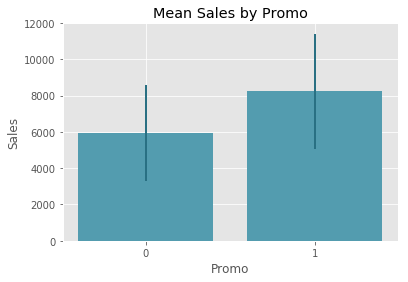

In [9]:
col = 'Promo'
mean_total_co_day = dat[[col, 'Sales']].groupby(col).agg(['mean', 'std'])
mean_total_co_day.columns = mean_total_co_day.columns.droplevel()

# Define a function for a bar plot
def barplot(x_data, y_data, error_data, x_label, y_label, title):
    '''
    input:  
        x_data: (group by dataframe based on column and sales)
        y_data: (column name to plot eg: mean sales)
        error_data: (column name for error bar eg: std)
        x_label: (str -- x label name)
        y_label: (str -- y label name)
        title: (str -- title name)
    bar plot based on input parameters eg: bar plot based on mean sales
    output: (No return, bar plot based on input parameters)
    '''
    _, ax = plt.subplots()
    # Draw bars, position them in the center of the tick mark on the x-axis
    ax.bar(x_data, y_data, color = '#539caf', align = 'center')
    # Draw error bars to show standard deviation, set ls to 'none'
    # to remove line between points
    ax.errorbar(x_data, y_data, yerr = error_data, color = '#297083', ls = 'none', lw = 2, capthick = 2)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)
    ax.set_xticks([0, 1])

# Call the function to create plot
barplot(x_data=mean_total_co_day.index.values, 
        y_data=mean_total_co_day['mean'], 
        error_data=mean_total_co_day['std'],
        x_label='Promo'
        , y_label = 'Sales'
        , title = 'Mean Sales by Promo')

In [10]:
def difference_sales_plot(col, y='Sales', dat=dat):
    '''
    input:  
        col: (column name to segment from dataframe, x variable)
        y: (y variable from dataframe to track)
    plot difference in sales based on 'col' with a seaborn factor plot 
    adds text to plot based on diffence in sales 
    output: (seaborn factor plot based on column with difference in Sales)
    '''
    
    tmp = pd.pivot_table(index=col, columns='Promo', values=y, data=dat).fillna(0)
    tmp['Diff'] = tmp.diff(axis=1)[1]

    sns.factorplot(x=col, y=y, data=dat, hue='Promo', kind='point', 
                   height=5, aspect=2.5)
    
    title_string = 'Difference in {} per {} based on if a Promotion is running'
    if col == 'DayOfWeek': title_string += ' (Monday=1, Sunday=7)'
    plt.title(title_string.format(y, col))
    
    style = dict(size=10, color='gray')
    for i, (diff, top, bot) in enumerate(zip(tmp['Diff'], tmp[1], tmp[0])):
        if diff > 0: 
            loc = ((top+bot)/2)
            plt.text(i, loc+(loc*.04), 'Difference', **style)
            plt.text(i, loc, str(round(diff)), **style) 
            
def box_plot(col, y='Sales'):
    '''
    input:  
        col: (column name to segment from dataframe, x variable)
        y: (y variable to track from dataframe)
    Plots box plot based on column name 
    output: (box plot based on Sales)
    '''
    fig, ax = plt.subplots(figsize=(25, 10))
    sns.boxplot(y=y, x=col, data=dat, hue='Promo', ax=ax);
    title_string = 'Box Plot for {} per {} based on if a Promotion is running'
    if col == 'DayOfWeek': title_string += ' (Monday=1, Sunday=7)'
    plt.title(title_string.format(y, col));

## Weekly

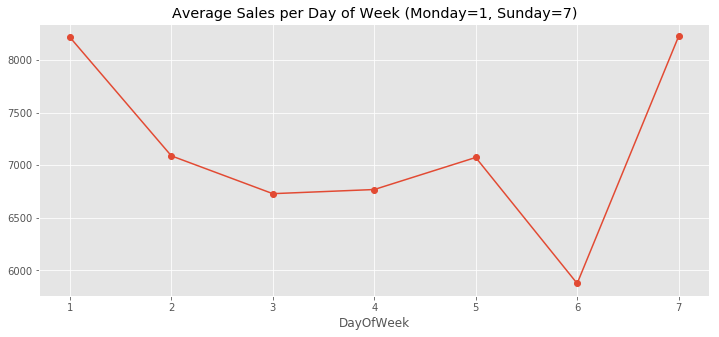

In [11]:
# Let us check how does the average spend per customer changes over the days of the week
dat.groupby('DayOfWeek').mean()['Sales'].plot(figsize=(12, 5), marker='o')
plt.title('Average Sales per Day of Week (Monday=1, Sunday=7)');
# Mondays and Sundays present best average sales and Saturday is the weakest

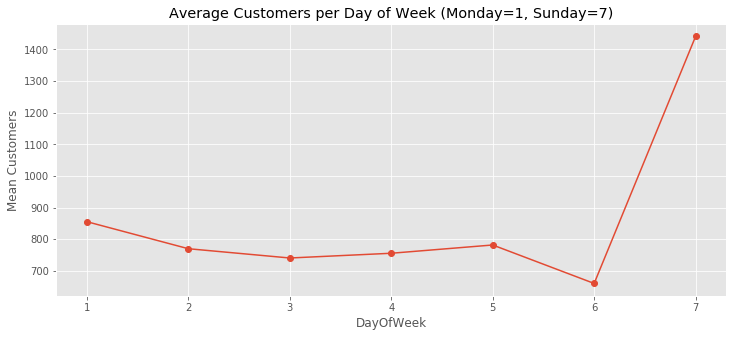

In [12]:
# Let us check how does the average spend per customer changes over the days of the week
dat.groupby('DayOfWeek').mean()['Customers'].plot(figsize=(12, 5), marker='o')
plt.title('Average Customers per Day of Week (Monday=1, Sunday=7)');
plt.ylabel('Mean Customers');
# Mondays and Sundays present best average sales and Saturday is the weakest

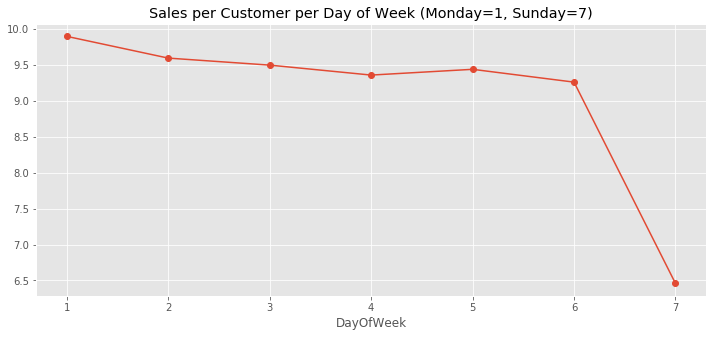

In [13]:
dat.groupby('DayOfWeek').mean()['SalesperCustomer'].plot(figsize=(12, 5), marker='o')
plt.title('Sales per Customer per Day of Week (Monday=1, Sunday=7)');

#From Monday peak of almost 10€ to as low as ~6.5€ on Sundays. 
# Following, for every day of the week, the average spend per customer depending on the month.

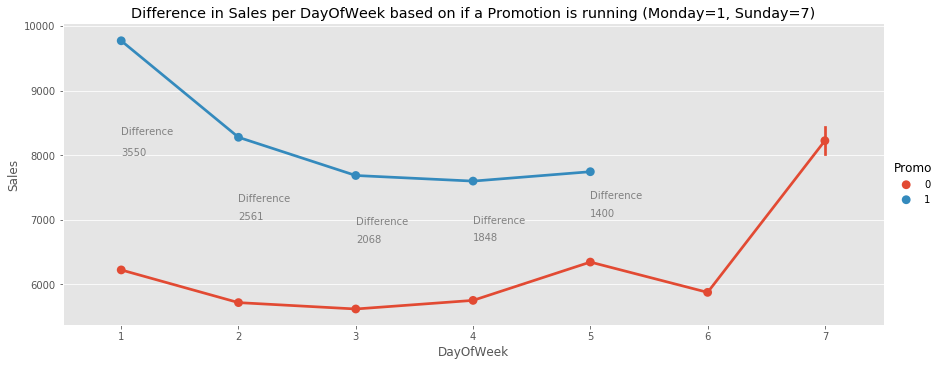

In [14]:
# What is the best day of the week to have a promo?
difference_sales_plot('DayOfWeek')

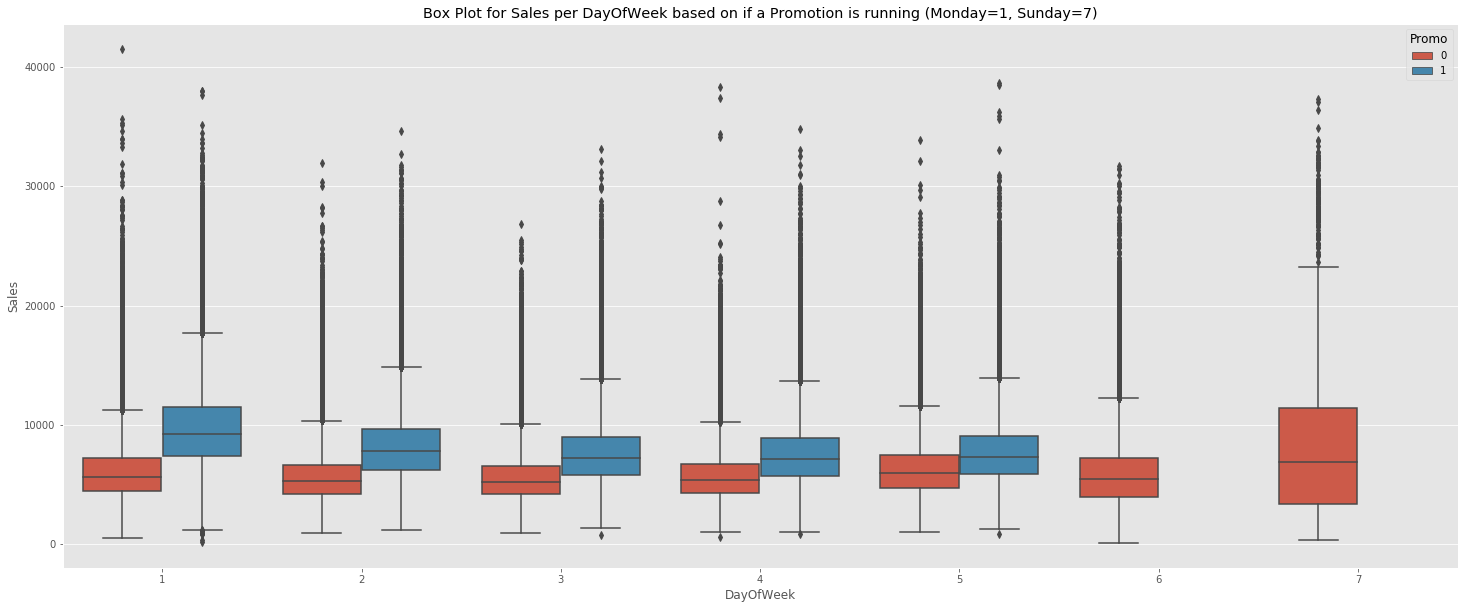

In [15]:
# Sales by Day of the week by Promo
box_plot('DayOfWeek')

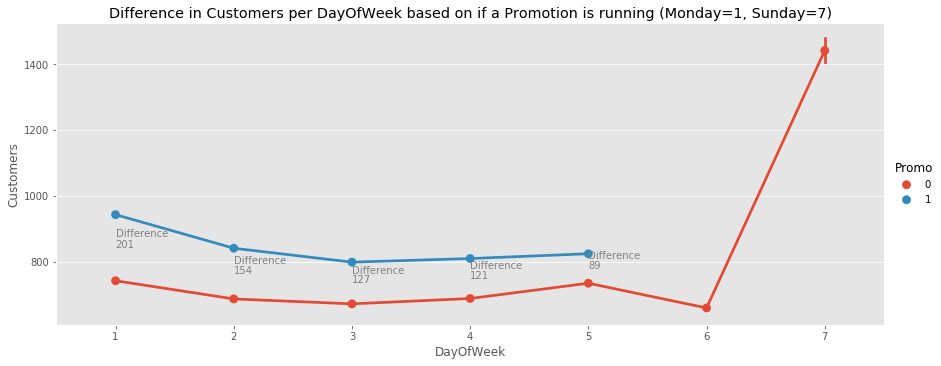

In [16]:
difference_sales_plot('DayOfWeek', 'Customers')

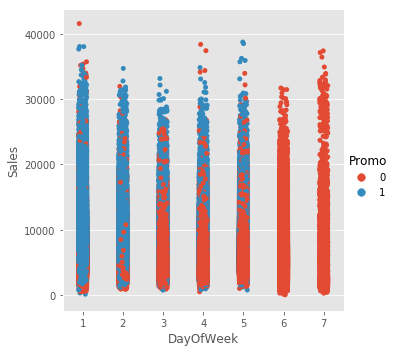

In [17]:
sns.catplot(x ="DayOfWeek", y = "Sales", data=dat, hue='Promo' ,sharex=False);

Thoughts
- First off we can see that the company doesn't run any promotions on the weekends. 
- We can clearly see that the biggest difference in promotion sales is on Mondays. 
- And the smallest difference is on Fridays. 

Future company thoughts
- Might want to look into starting some promotions on Saturdays (or moving Friday's promotions to Saturday), to get some more customers and sales in the stores. Sunday seems like they don't need to include any promotions, since we see a large number of customers in the stores.

## Monthly 

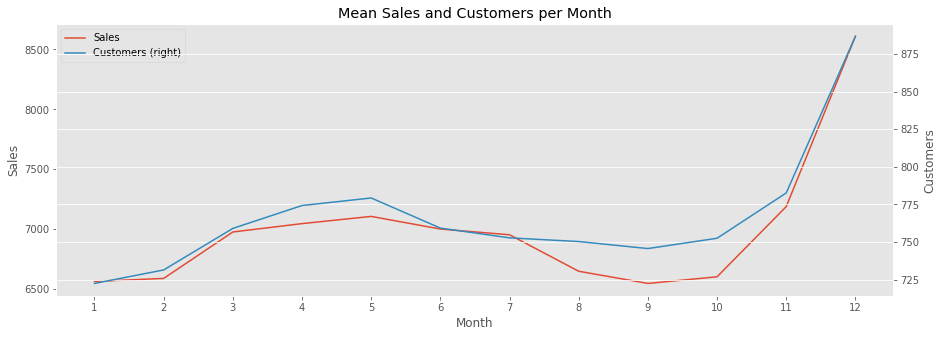

In [18]:
# We can plot Sales and Customers based on the month
ax = dat.groupby('Month')[['Sales', 'Customers']].mean().plot(secondary_y=['Customers'], figsize=(15, 5));
plt.title('Mean Sales and Customers per Month');
ax.set_ylabel('Sales')
ax.right_ax.set_ylabel('Customers');
ax.set_xticks(range(1, 13));
# around Christmas times, customers spend the most. However, the other peaks are in March and July.

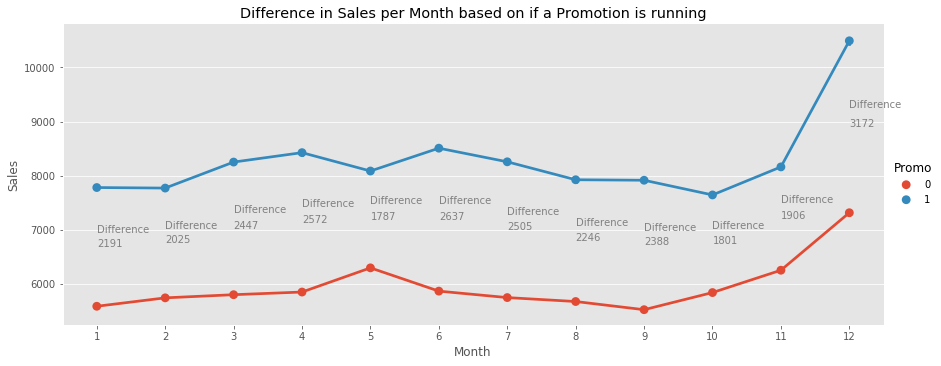

In [19]:
# What is the best month of the year to have a promo?
difference_sales_plot('Month')

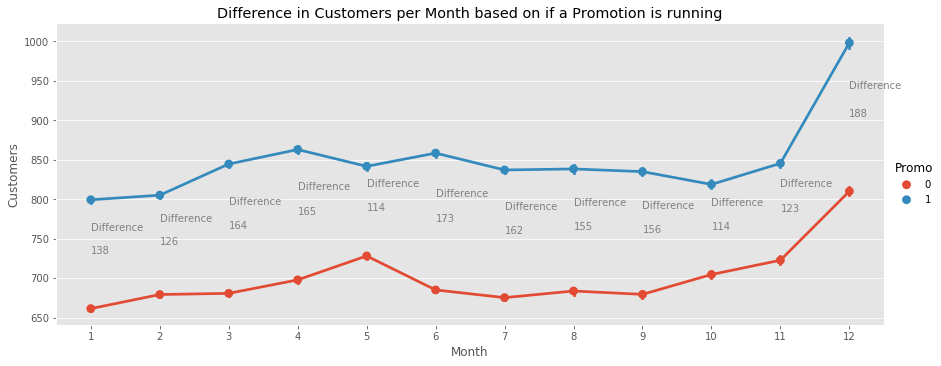

In [20]:
difference_sales_plot('Month', 'Customers')

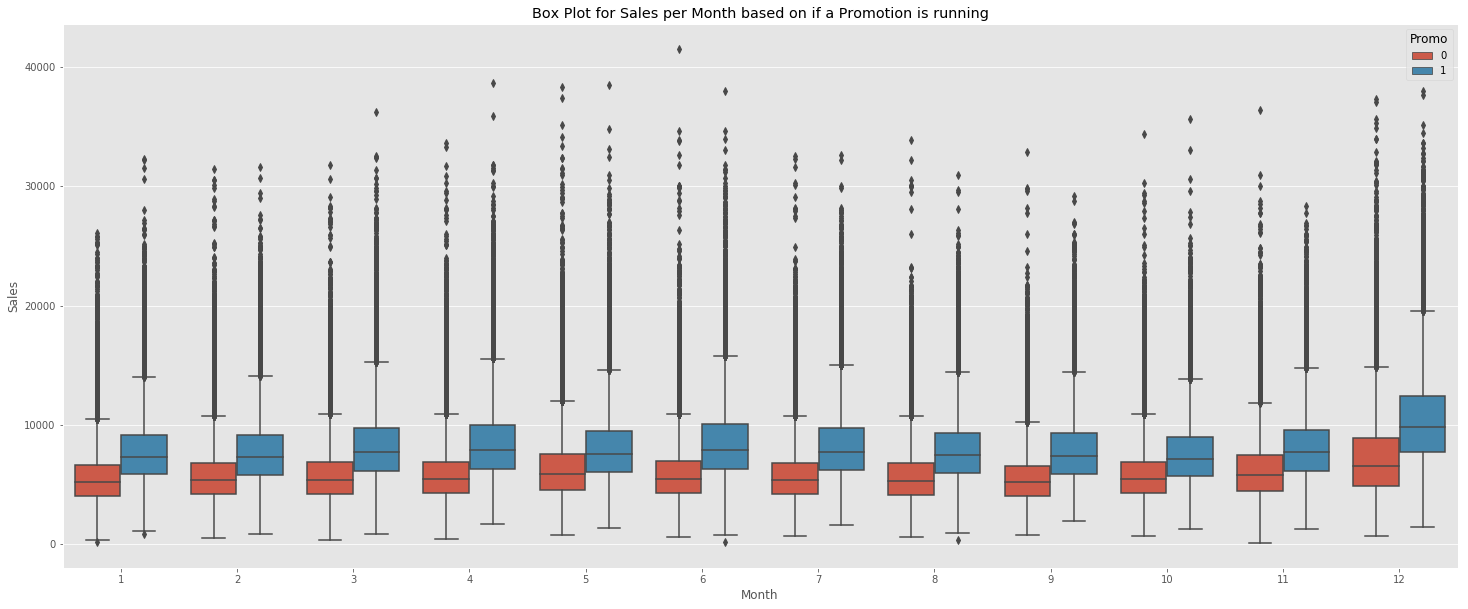

In [21]:
# Sales by Day of the week by Promo
box_plot('Month')

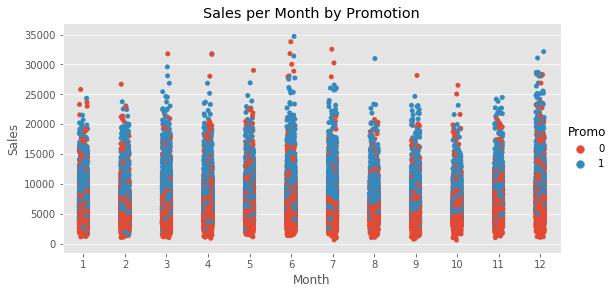

In [22]:
sns.catplot(x ="Month", y = "Sales", data=dat.sample(50000), hue='Promo',height=4, aspect=2)
plt.title('Sales per Month by Promotion');

Thoughts
- December Sales and Customers are the highest with promotion and without promotions. But also have the largest IQR and variance, so it seems that this month is the most volatile (which does make sense with the holidays) 
- Seems as the months of May, October and November have some jumps in Sales and Customers without promotions. Therefore the difference between days with promotion and without promotions aren't as high. Seems like customers will tend to shop more on these months regardless of having promotions. 

## Holiday

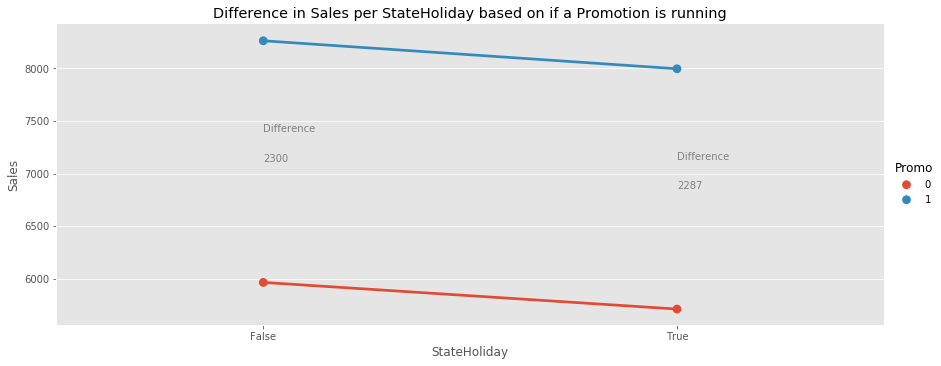

In [148]:
difference_sales_plot('StateHoliday')

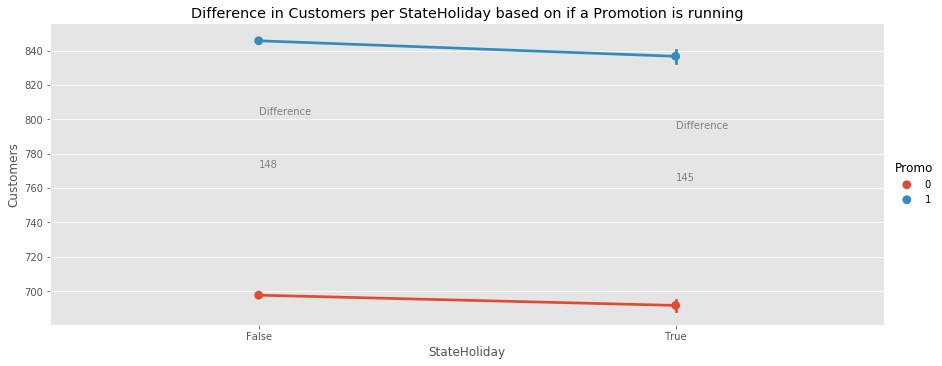

In [150]:
difference_sales_plot('StateHoliday', 'Customers')

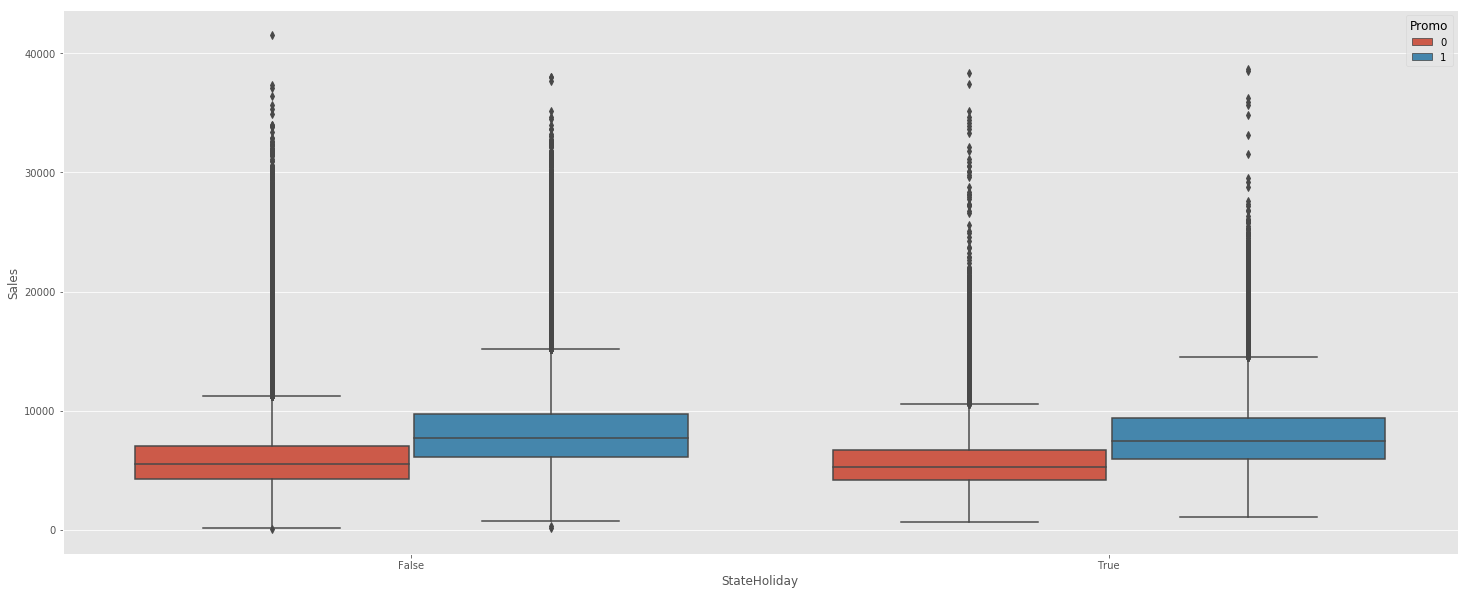

In [152]:
box_plot('StateHoliday')

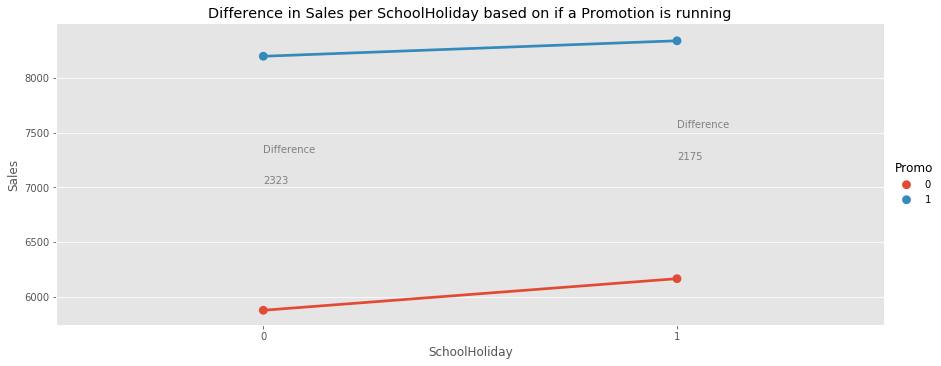

In [149]:
difference_sales_plot('SchoolHoliday')

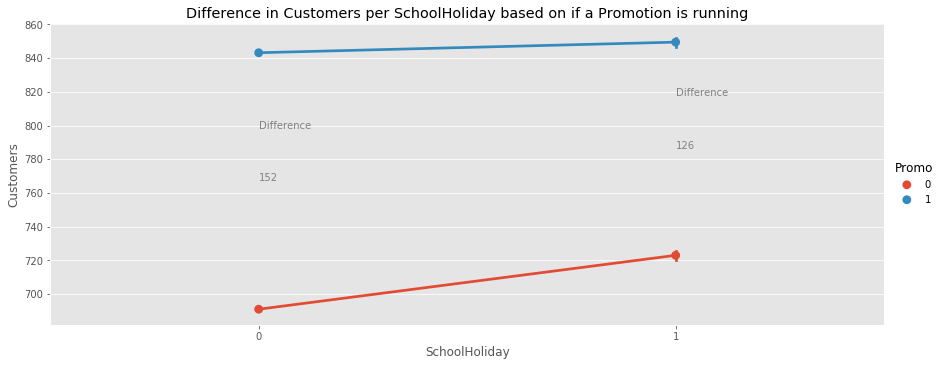

In [151]:
difference_sales_plot('SchoolHoliday', 'Customers')

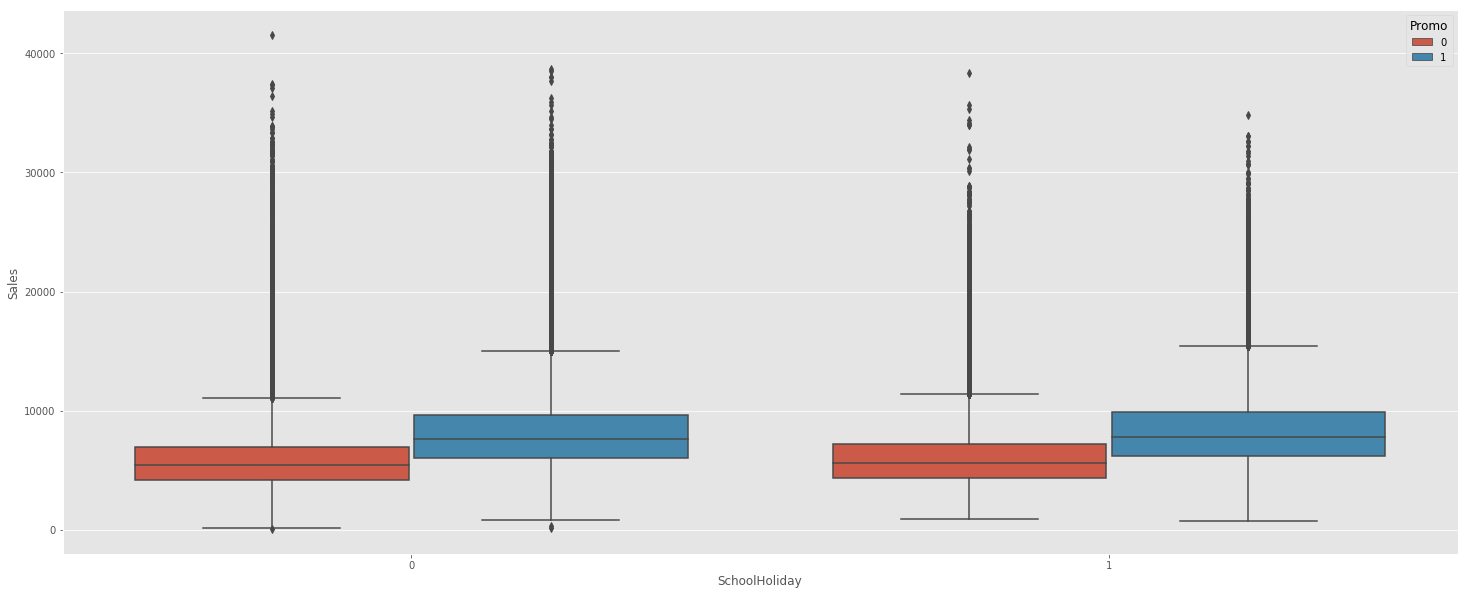

In [153]:
box_plot('SchoolHoliday')

### Days before and after holidays

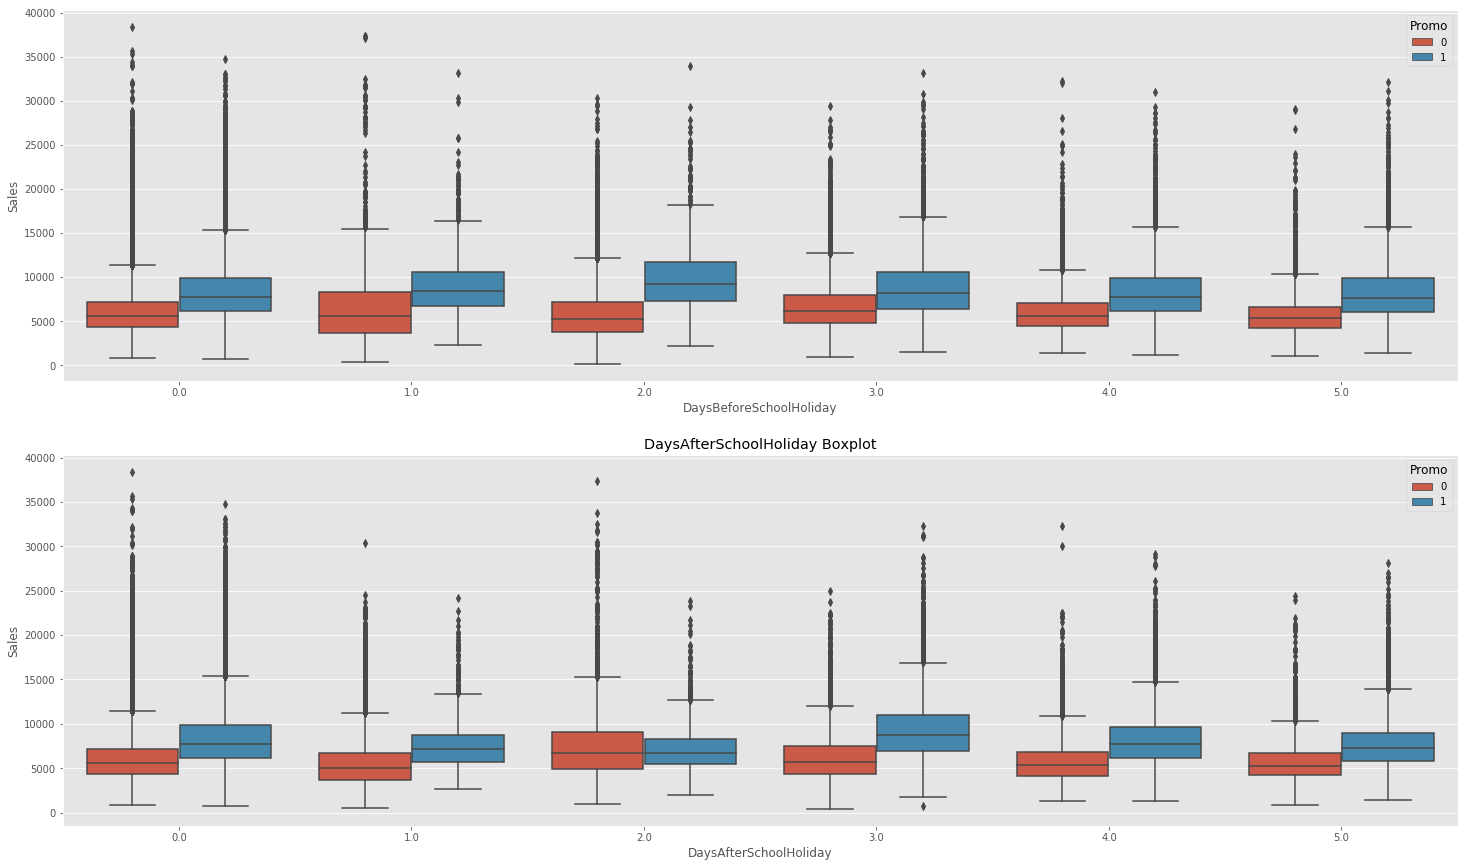

In [59]:
days_before_school_holiday = dat[(dat['DaysBeforeSchoolHoliday'] >= 0) & (dat['DaysBeforeSchoolHoliday'] <= 5)]
days_after_school_holiday = dat[(dat['DaysAfterSchoolHoliday'] >= 0) & (dat['DaysAfterSchoolHoliday'] <= 5)]


fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(25, 15))
sns.boxplot(y='Sales', x='DaysBeforeSchoolHoliday', 
            data=days_before_school_holiday, 
            hue='Promo', ax=ax1)
plt.title('DaysBeforeSchoolHoliday Boxplot');


sns.boxplot(y='Sales', x='DaysAfterSchoolHoliday', 
            data=days_after_school_holiday, 
            hue='Promo', ax=ax2)
plt.title('DaysAfterSchoolHoliday Boxplot');

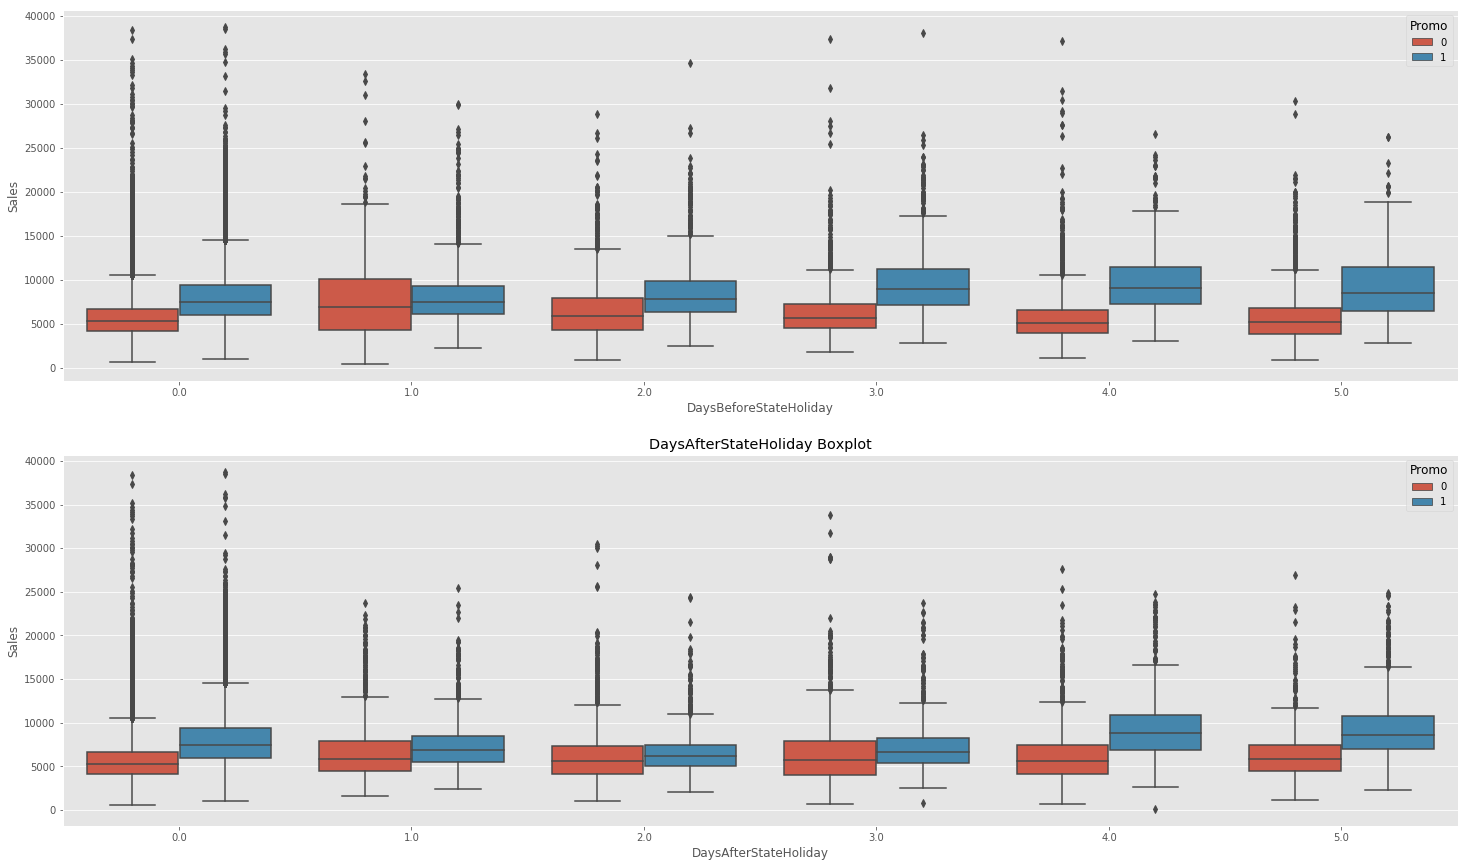

In [55]:
days_before_state_holiday = dat[(dat['DaysBeforeStateHoliday'] >= 0) & (dat['DaysBeforeStateHoliday'] <= 5)]
days_after_state_holiday = dat[(dat['DaysAfterStateHoliday'] >= 0) & (dat['DaysAfterStateHoliday'] <= 5)]


fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(25, 15))
sns.boxplot(y='Sales', x='DaysBeforeStateHoliday', 
            data=days_before_state_holiday, 
            hue='Promo', ax=ax1)
plt.title('DaysBeforeStateHoliday Boxplot');


sns.boxplot(y='Sales', x='DaysAfterStateHoliday', 
            data=days_after_state_holiday, 
            hue='Promo', ax=ax2)
plt.title('DaysAfterStateHoliday Boxplot');

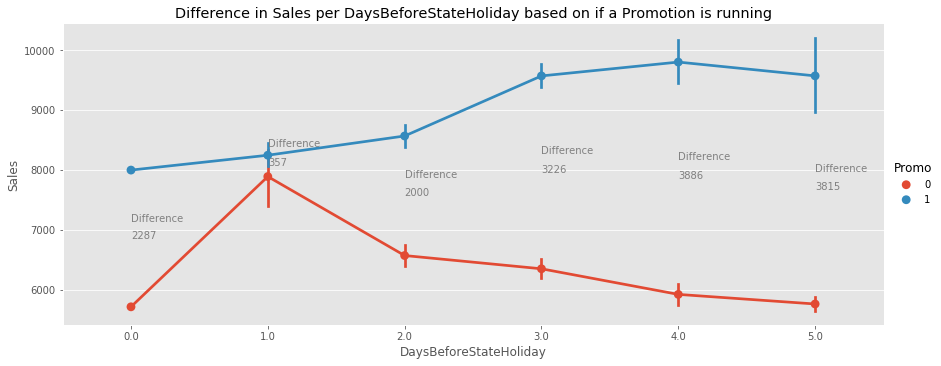

In [56]:
difference_sales_plot('DaysBeforeStateHoliday', dat=days_before_state_holiday)

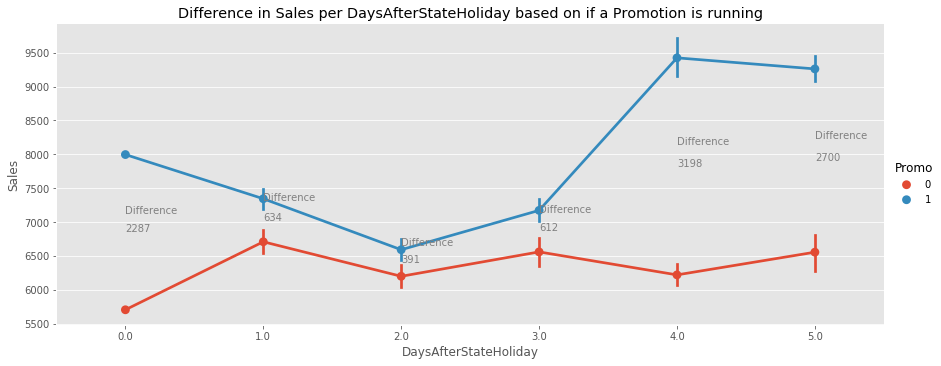

In [57]:
difference_sales_plot('DaysAfterStateHoliday', dat=days_after_state_holiday)

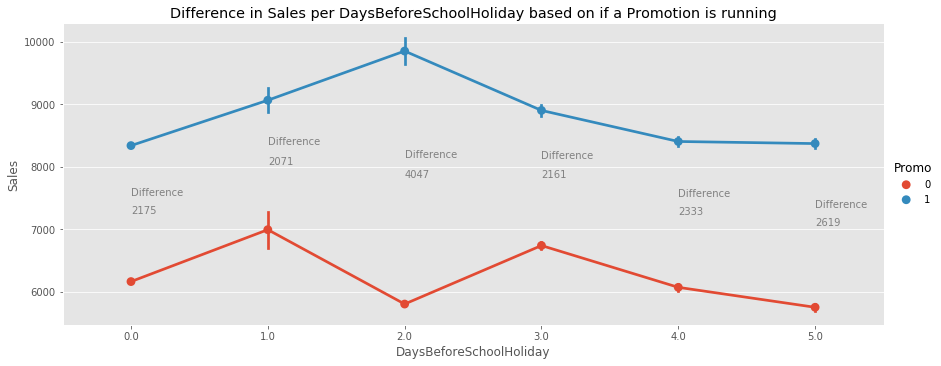

In [60]:
difference_sales_plot('DaysBeforeSchoolHoliday', dat=days_before_school_holiday)

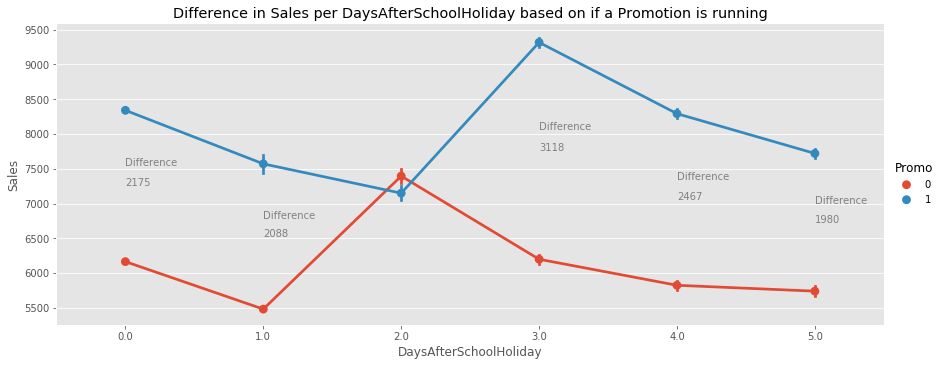

In [61]:
difference_sales_plot('DaysAfterSchoolHoliday', dat=days_after_school_holiday)

Thoughts
- Some interesting things here. We can see that actually see that
- one day before a 'state' holiday the spending isn't too high (many people probably aren't going to shop anyway), but it really isn't going to matter if there is a promo going on during this day. Seems like people are going to shop regardless if they actually need to. 
- We can also see that in both 2 DaysAfterSchoolHoliday and 2 DaysAfterStateHoliday that promotions don't have too much effect on sales. In fact, having a promotion 2 DaysAfterSchoolHoliday is actually worse than not having one at all. Might want to drop potential promotions on these days. Although it is interesting that the difference greatly increases in later days. 

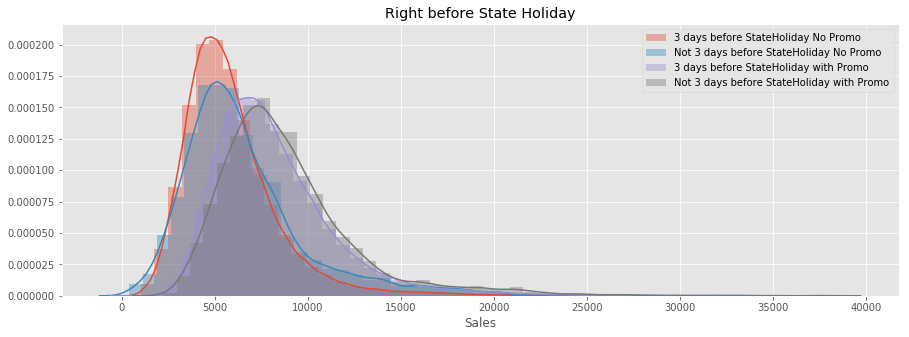

In [171]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.distplot(dat[(dat.StateHoliday == False) & (dat.DaysBeforeStateHoliday > 3) & (dat.Promo == 0)].Sales, label='3 days before StateHoliday No Promo', ax=ax)
sns.distplot(dat[(dat.StateHoliday == False) & (dat.DaysBeforeStateHoliday <= 3) & (dat.Promo == 0)].Sales, label='Not 3 days before StateHoliday No Promo', ax=ax)
sns.distplot(dat[(dat.StateHoliday == False) & (dat.DaysBeforeStateHoliday > 3) & (dat.Promo == 1)].Sales, label='3 days before StateHoliday with Promo', ax=ax)
sns.distplot(dat[(dat.StateHoliday == False) & (dat.DaysBeforeStateHoliday <= 3) & (dat.Promo == 1)].Sales, label='Not 3 days before StateHoliday with Promo', ax=ax)
plt.legend()
plt.title('Right before State Holiday');

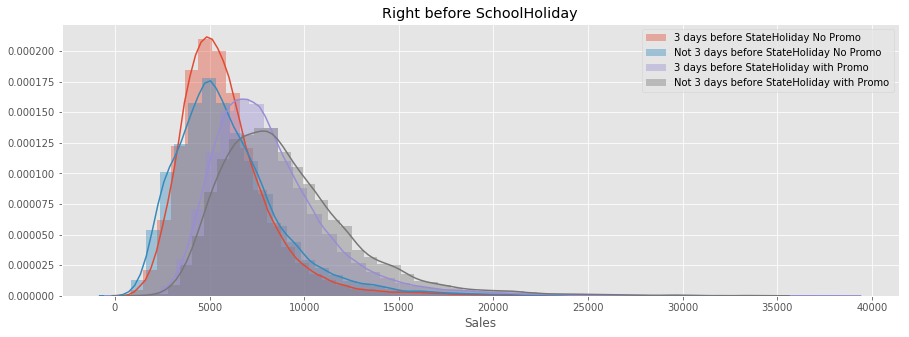

In [172]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.distplot(dat[(dat.SchoolHoliday == False) & (dat.DaysBeforeSchoolHoliday > 3) & (dat.Promo == 0)].Sales, label='3 days before StateHoliday No Promo', ax=ax)
sns.distplot(dat[(dat.SchoolHoliday == False) & (dat.DaysBeforeSchoolHoliday <= 3) & (dat.Promo == 0)].Sales, label='Not 3 days before StateHoliday No Promo', ax=ax)

sns.distplot(dat[(dat.SchoolHoliday == False) & (dat.DaysBeforeSchoolHoliday > 3) & (dat.Promo == 1)].Sales, label='3 days before StateHoliday with Promo', ax=ax)
sns.distplot(dat[(dat.SchoolHoliday == False) & (dat.DaysBeforeSchoolHoliday <= 3) & (dat.Promo == 1)].Sales, label='Not 3 days before StateHoliday with Promo', ax=ax)

plt.legend()
plt.title('Right before SchoolHoliday');

### Seasonality 

Question
- Are we seeing seasonality trends in the sales and number of customers?

In [23]:
def time_plot(col):
    '''
    input:  col: (column name to plot from `dat` dataframe)
    group by column based on 'col' and plots 'Sales' and 'Customers' on different axises 
    output: (pandas plot based on mean of Sales and Customers)
    '''
    ax = dat.groupby(col)[['Sales', 'Customers']].mean().plot(secondary_y=['Customers'], figsize=(20, 5));
    plt.title('Mean Sales and Customers per {}'.format(col));
    ax.set_ylabel('Sales')
    ax.right_ax.set_ylabel('Customers');

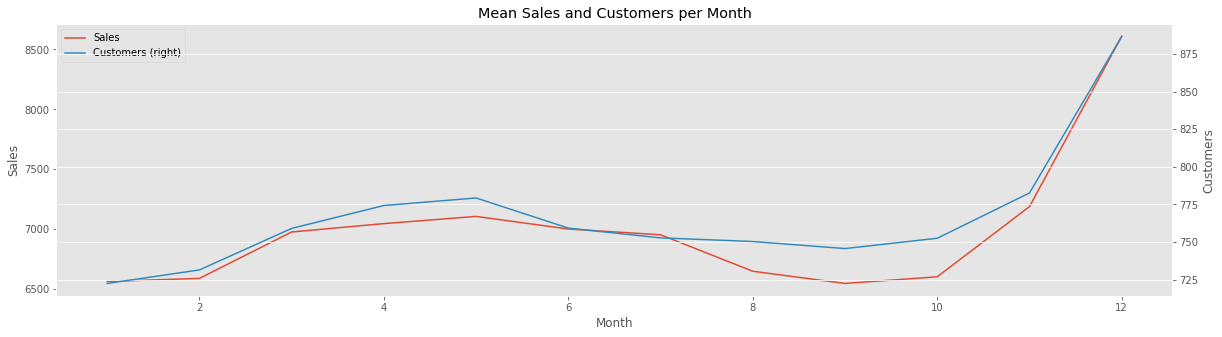

In [24]:
time_plot('Month')

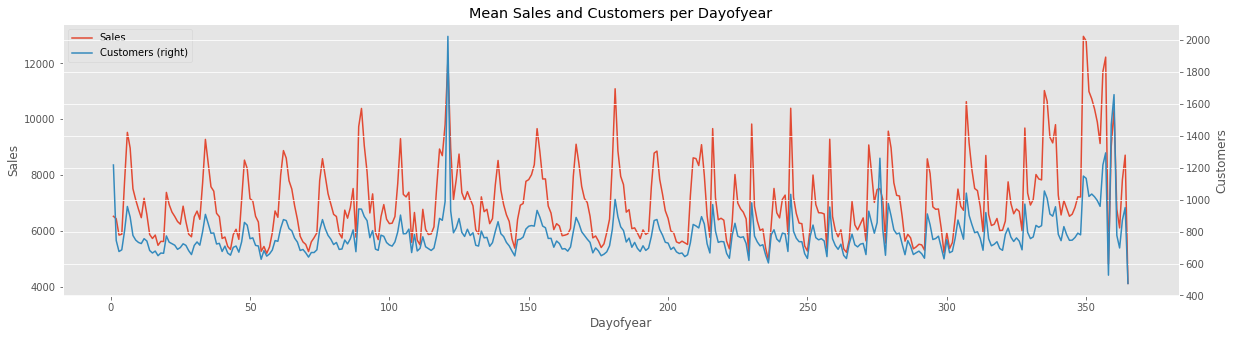

In [27]:
time_plot('Dayofyear')

As we saw before around Christmas times, customers spend the most. However, the other peaks are in March and July. But this is just mean values, does this represent the typical trend month over multiple years?  

We can also see that the number of customers and Sales numbers are quite consistant over the time periods. 

***
***
***
***
***
***
***
***

# Question 2

### Do we see seasonality and trends in the store data? Are stores doing well?We can analyze some Time Series Analysis. Analysis per store type and correlational analysis of stores activity.

## time series analysis

In [28]:
# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# prophet by Facebook
from fbprophet import Prophet

In [29]:
time_series_dat = dat.copy()

In [30]:
def get_store(store_id, df=time_series_dat):
    """
    input:  
        store_id: (id of store from pandas dataframe)
        df: (pandas dataframe)
    For a given store, return the daily sales formated for prophet
    output: (store data)
    """
    store = df[df.Store == store_id][['Date', 'Sales']]
    store = store.rename(columns={'Date': 'ds','Sales': 'y'}).sort_values('ds')
    return store


# [Facebook's Prophet](https://research.fb.com/prophet-forecasting-at-scale/)
# It is based on an additive model where non-linear trends are fit with yearly and weekly seasonality, plus holidays. 
def fit_prophet(store_id, train_percent=0.8, holidays=None):
    """
    input:  
        store_id: (int -- id of store from pandas dataframe)
        train_percent: (int -- percent of data used for training)
        holidays: (holiday pandas dataframe)
    Given a store ID, take ~`train_percent` of the data
    for training of the prophet
    output: (prophet model, store data , number of training points)
    """
    data = get_store(store_id)
    N = int(np.floor(train_percent * len(data)))  
    prophet = Prophet(interval_width=0.95, holidays=holidays)
    prophet.fit(data[:N]) 
    return prophet, data, N

Choose 4 different stores for analysis. Choose four different 'store types' and located in different states for some variety. 

In [73]:
# store type 'd' - SchleswigHolstein
store15 = get_store(15).set_index('ds')
# store type 'a' - NordrheinWestfalen
store1111 = get_store(1111).set_index('ds')
# store type 'b' State - Berlin
store85 = get_store(85).set_index('ds')
# store type 'c' - Sachsen
store1017 = get_store(1017).set_index('ds')

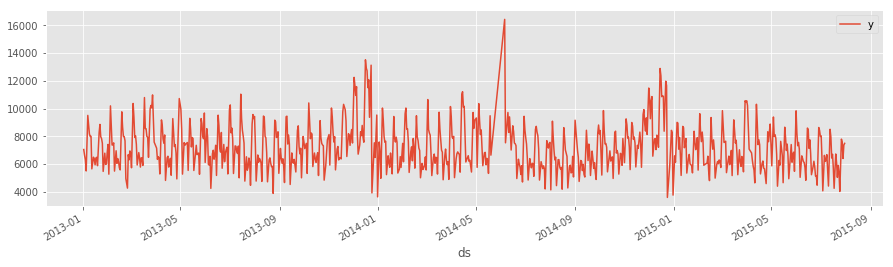

In [161]:
# plot daily sales
get_store(1017).set_index('ds').plot(figsize=(15, 4));

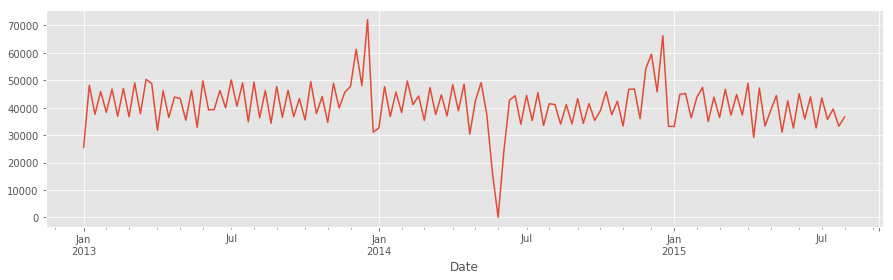

In [162]:
test_store = train[train.Store == 1017]
test_store['Date'] = pd.to_datetime(test_store['Date'])
test_store = test_store.set_index('Date')['Sales'] * 1.0 
test_store.resample('W').sum().plot(figsize=(15, 4))

- Is there an overall trend in your data that you should be aware of? Does the data show any seasonal trends? This is important when deciding which type of model to use. If there isn’t a seasonal trend in your data, then you can just use a regular ARIMA model instead. If you are using daily data for your time series and there is too much variation in the data to determine the trends, you might want to look at resampling your data by month, or looking at the rolling mean.
- Another tool to visualize the data is the `seasonal_decompose` function in statsmodel. With this, the trend and seasonality become even more obvious.
- The residual values essentially take out the trend and seasonality of the data, making the values independent of time. You could try to model the residuals using exogenous variables, but it could be tricky to then try and convert the predicted residual values back into meaningful numbers.

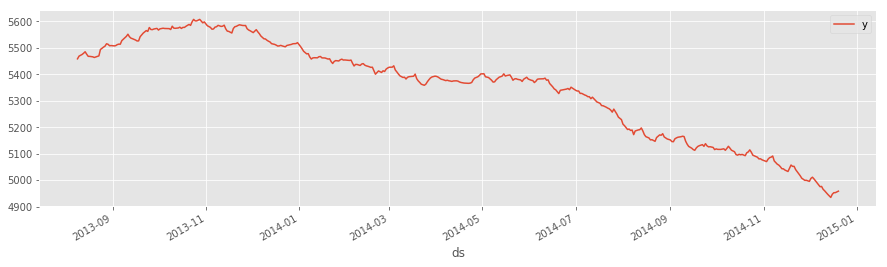

In [127]:
# yearly heck  presence of a trend in series.
store1 = get_store(1111)
seasonal_decompose(store1.set_index('ds'), model='additive', freq=365).trend.plot(figsize=(15, 4));

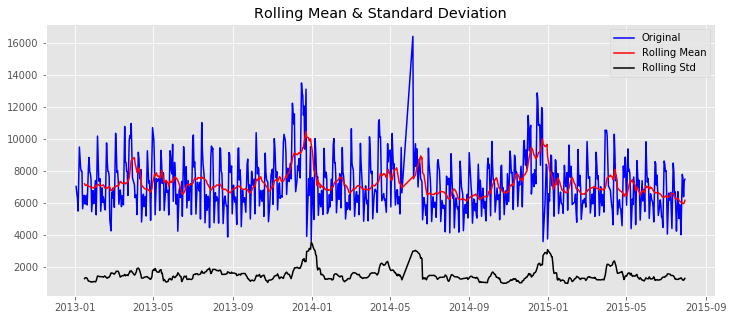

Results of Dickey-Fuller Test:
Test Statistic                  -4.553938
p-value                          0.000157
#Lags Used                      13.000000
Number of Observations Used    753.000000
Critical Value (1%)             -3.439064
Critical Value (5%)             -2.865386
Critical Value (10%)            -2.568818
dtype: float64


In [139]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    '''
    input:  
        timeseries: (pandas store dataframe)
    Computes and plots the rolling mean and std 
    Plots the original time series with rolling mean and std 
    Computes and prints Dickey-Fuller Test
    output: 
        (plot of original time series with rolling mean and std, results from Dickey-Fuller Test)
    '''
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics:
    plt.figure(figsize=(12, 5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
#     print(adfuller(timeseries, autolag='AIC'))
    dftest = adfuller(timeseries['y'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(store1017)

The [Augmented Dickey-Fuller test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) is a type of statistical test called a [unit root test](https://en.wikipedia.org/wiki/Unit_root_test).

The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.

It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

- The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). 
- The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [168]:
def plot_components_stats(store, resample=None):
    '''
    input:  
        store: (pandas store dataframe)
        resample: ('W': week resample, 'M': month resample)
    computes the seasonal decomposion with statsmodels
    and plots the original trend, seasonality, and residuals of the store data
    output: (plots original and seasonal_decompose trend, seasonal, residual based on store in four plots)
    '''
    f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (15, 10), sharex=True)
    freq = 365
    if resample:
        store = store.resample(resample).sum()
        if resample == 'W': freq = 52
        if resample == 'M': freq = 12
    decomposition = seasonal_decompose(store, model='multiplicative', freq=freq)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    ax1.plot(store, label='Original')
    ax1.set_title('Original Series')
    ax1.legend()
    ax2.plot(trend, label='Trend')
    ax2.set_title('Trend Series')
    ax2.legend()
    ax3.plot(seasonal,label='Seasonality')
    ax3.set_title('Seasonality Series')
    ax3.legend()
    ax4.plot(residual, label='Residuals')
    ax4.set_title('Residuals Series')
    ax4.legend()
    ax4.set_xlabel('date');

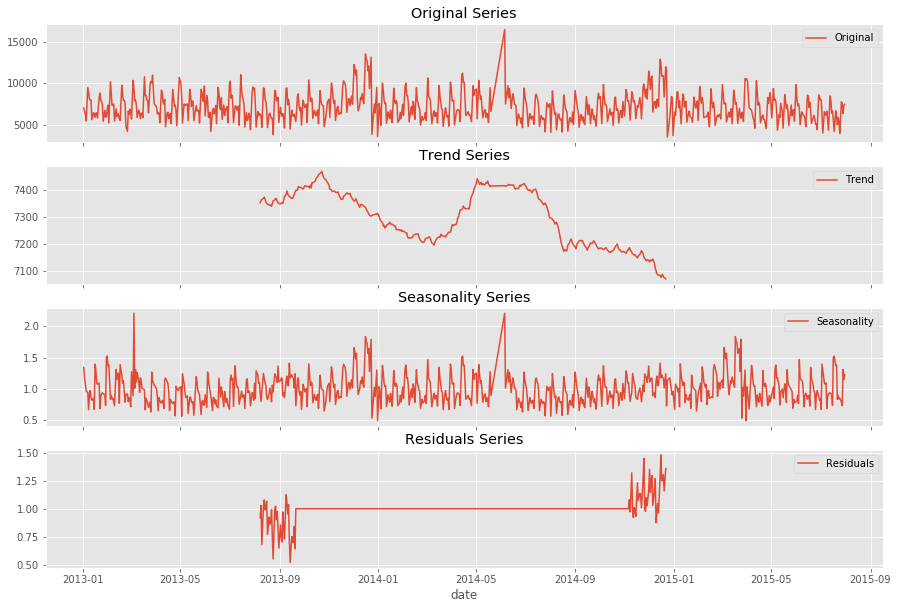

In [177]:
plot_components_stats(store1017)

In [167]:
# plot_components_stats(store15, resample='W')

In [164]:
# plot_components_stats(store85)

A plot of the autocorrelation of a time series by lag is called the AutoCorrelation Function, or the acronym ACF. This plot is sometimes called a correlogram or an autocorrelation plot.

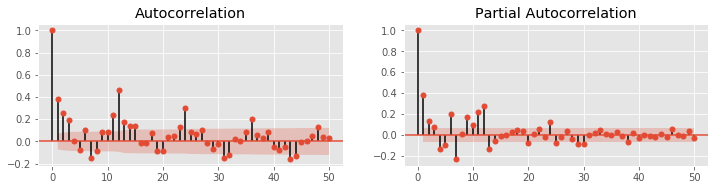

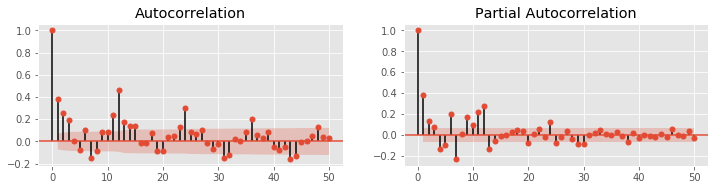

In [183]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(12, 12))
plt.subplot(423); plot_acf(store1017, lags = 50, ax = plt.gca())
plt.subplot(424); plot_pacf(store1017, lags = 50, ax = plt.gca())

In [114]:
import statsmodels.api as sm  

mod = sm.tsa.statespace.SARIMAX(store1017, trend='n', order=(0,1,0), seasonal_order=(1,1,1,12))
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  767
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood               -6675.144
Date:                            Sat, 25 Aug 2018   AIC                          13356.287
Time:                                    11:40:00   BIC                          13370.164
Sample:                                         0   HQIC                         13361.633
                                            - 767                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.3469      0.023     15.032      0.000       0.302       0.392
ma.S.L12      -0.9994      0.027   

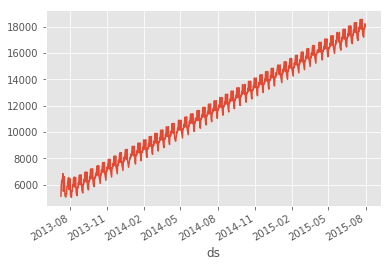

In [157]:
results.predict(len(store1) - N, dynamic= True).plot()

In [187]:
prophet_basic, prophet_store, N = fit_prophet(store_id=1017)
# create future dataframe 
test_df = prophet_basic.make_future_dataframe(len(prophet_store) - N)
year_df = prophet_basic.make_future_dataframe(periods=365)
# predict future dates 
forcast_store1_test_df = prophet_basic.predict(test_df)
forcast_store1_year_df = prophet_basic.predict(year_df)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


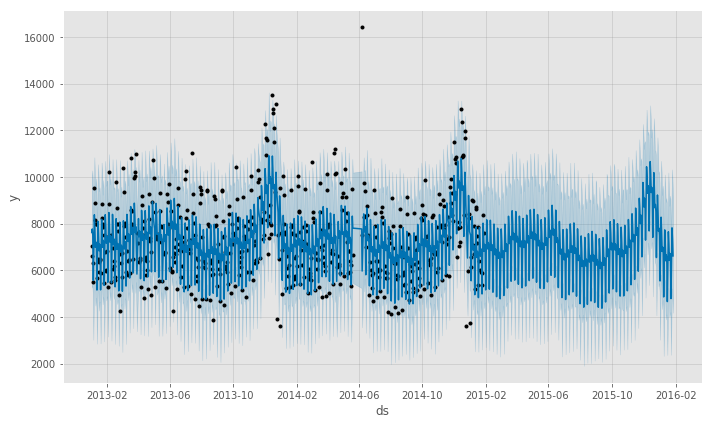

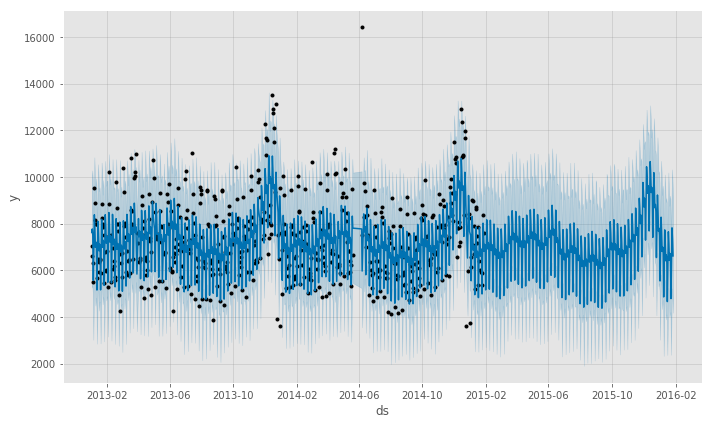

In [188]:
# Prophet plots the observed values of our time series (the black dots), 
# the forecasted values (blue line) and the uncertainty intervals of our forecasts (the blue shaded regions).
prophet_basic.plot(forcast_store1_year_df)

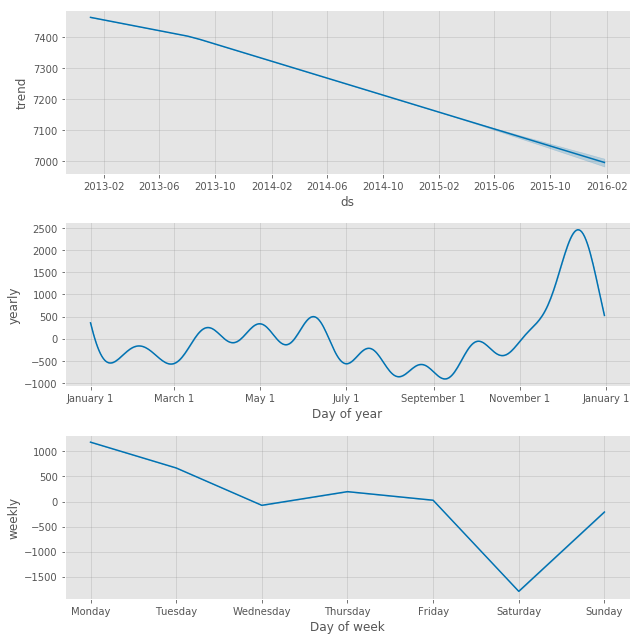

In [189]:
prophet_basic.plot_components(forcast_store1_year_df, weekly_start=1);

In [190]:
# add holidays
state_holiday_dates = time_series_dat[time_series_dat['StateHoliday'] == True].loc[:, 'Date'].values
school_holiday_dates = time_series_dat[time_series_dat['SchoolHoliday'] == 1].loc[:, 'Date'].values
state = pd.DataFrame({'holiday': 'state_holiday', 'ds': state_holiday_dates})
school = pd.DataFrame({'holiday': 'school_holiday', 'ds': school_holiday_dates})
holidays = pd.concat((state, school))      

In [191]:
prophet_holiday, prophet_store, N = fit_prophet(store_id=1017, holidays=holidays)
# create future dataframe 
test_df_holiday = prophet_holiday.make_future_dataframe(len(prophet_store) - N)
year_df_holiday = prophet_holiday.make_future_dataframe(periods=365)
# predict future dates 
forcast_store1_test_df_holiday = prophet_holiday.predict(test_df_holiday)
forcast_store1_year_df_holiday = prophet_holiday.predict(year_df_holiday)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


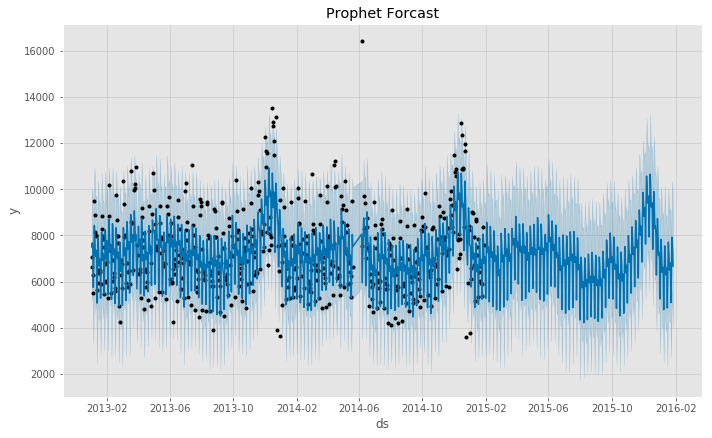

In [195]:
prophet_holiday.plot(forcast_store1_year_df_holiday);
plt.title('Prophet Forcast');

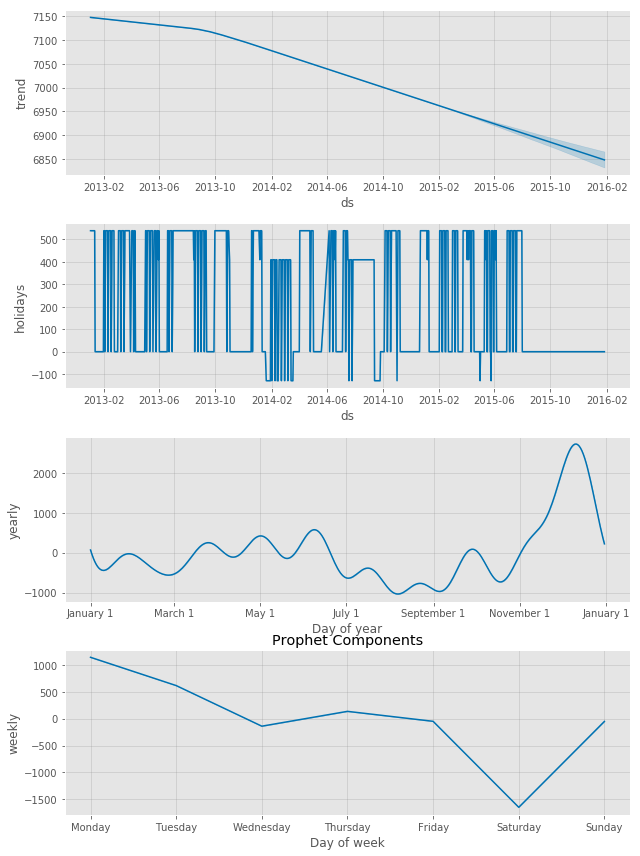

In [196]:
prophet_holiday.plot_components(forcast_store1_year_df_holiday, weekly_start=1)
plt.title('Prophet Components');